In [1]:
# Initialization
%load_ext autoreload
%autoreload 2
import sys
import os
import pathlib

# To be able to reference packages/modules in this repository, this
# relative path must be added to the python path. Your notebook may be 
# in a different folder, so modify this variable to point to the src 
# folder.
proj_src_root = pathlib.Path().absolute()
proj_root_path = proj_src_root.parent
data_path = proj_root_path.parent / ('cs6945share/cracks/rdd2020_exploded')

if proj_root_path.as_posix() not in sys.path:
    sys.path.insert(0, proj_root_path.as_posix())
    print("Updated Python Path")

print(f"Project Root Path: {proj_root_path}")
print(f"Project Source Root Path: {proj_src_root}")
print(f"Project Data Path: {data_path}")

assert(data_path.exists())

Updated Python Path
Project Root Path: /home/default/workspace/cracks
Project Source Root Path: /home/default/workspace/cracks/notebooks
Project Data Path: /home/default/workspace/cs6945share/cracks/rdd2020_exploded


In [2]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
import torchvision
from tqdm import tqdm
from torchinfo import summary
import time
import pandas as pd
from matplotlib import patches
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import train.transforms as transforms


debug = False

print("Pytorch: \t", torch.__version__)
if (not debug) and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("Device:     \t CPU")
    device='cpu'

Pytorch: 	 1.10.1
GPU:         	 NVIDIA A100 80GB PCIe MIG 7g.79gb
Memory Usage:	 0.0 GB /  0.0 GB


In [3]:
import custom_transformations as C

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        
        C.RandomIoUCrop(min_scale=0.8),
        
#         http://pytorch.org/vision/master/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter
        C.ColorJitter(contrast=[1, 1.1], hue=.1), 
        
        transforms.ToTensor(),
        # Normalization numbers are from here: https://pytorch.org/vision/stable/models.html
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        # Normalization numbers are from here: https://pytorch.org/vision/stable/models.html
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

ColorJitter(brightness=None, contrast=[1, 1.1], saturation=None, hue=[-0.1, 0.1])


In [4]:
training_path = data_path  / 'training'
val_path = data_path  / 'val'

In [5]:
if not (val_path / 'labels').exists():
    print("Renaming folders in 'val' subfolder.")
    os.rename(val_path/'image', val_path/'images')
    os.rename(val_path/'label', val_path/'labels')
else:
    print("'val' folder is proper.")

'val' folder is proper.


In [6]:
f = [y for y in (training_path/'labels').glob('[JC]*')] 
len(f)

12013

In [7]:
important_cats = ['D00','D10', 'D20', 'D40']

categories = {
important_cats[i]: i+1 for i in range(len(important_cats))
}

categories_dict = {v: k for k, v in categories.items()}
print(categories)
print(categories_dict)

{'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}
{1: 'D00', 2: 'D10', 3: 'D20', 4: 'D40'}


# Custom Dataset to parse Kitti Data

In [8]:
from PIL import Image


class CracksDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, sample=None,transform=None):
        self.imageDict = imageDict = {}
        self.annoDict = annoDict = {}
        self.base_dir = base_dir
        
        annId = 0
        imageId = 0
        categoryId = 1
        boxes_dropped = 0
        f = [y for y in (base_dir/'labels').glob('[JC]*')] 
        print(f"Found {len(f)} images in {base_dir}")
        if sample:
            f = random.sample(f, sample)
            print(f"Sampled {sample} images from that.")
            
        for image in f:
            imageDict[imageId] = image.stem
            nodata=image.stat().st_size == 0
            if not nodata:
                df = pd.read_csv(image,delimiter=' ',header=None)
                df = df[df[0].isin(important_cats)]
                if len(df) == 0:
                    nodata=True
                boxes_orig = len(df.index)
                df = df[((df.iloc[:,6] - df.iloc[:,4]) > 0.5) & ((df.iloc[:,7] - df.iloc[:,5]) > 0.5)]
                boxes_dropped += boxes_orig - len(df.index) 
                boxes = df.iloc[:,4:8].to_numpy()
                cats = [categories[i] for i in df.iloc[:,0].tolist()]

                iscrowd = torch.zeros((len(cats),), dtype=torch.int64)
                
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
                area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])


                
                annoDict[imageId] = {
                    'labels':torch.tensor(cats).type(torch.int64),
                    'boxes':boxes,
                    'image_id':torch.tensor([imageId]),
                    'area':area,
                    'iscrowd':iscrowd
                }
            if nodata:
                annoDict[imageId] = {
                    'labels':torch.tensor([]).type(torch.int64),
                    'boxes':torch.as_tensor(np.array([]), dtype=torch.float32).reshape(-1, 4),
                    'image_id':torch.tensor([imageId]),
                    'area':torch.tensor([]).type(torch.float32),
                    'iscrowd':torch.tensor([]).type(torch.int64)
                    
                }
            imageId += 1
        self.transform = transform
        print(f"Dropped {boxes_dropped} boxes because of 0 area")
    
    def getImagePath(self,idx):
        return (self.base_dir/'images'/(self.imageDict[idx] + '.jpg')).as_posix()

    def __len__(self):
        return len(self.imageDict)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            idx = idx.item()
        img_path = self.getImagePath(idx)
        image = Image.open(img_path)
        if idx in self.annoDict:
            label = self.annoDict[idx]
        else:
            label = None
        if self.transform:
            image, label = self.transform(image, label)
        return image, label

In [9]:
intermediate = proj_src_root/'intermediate'

assert intermediate.exists()

In [10]:
import pickle
sample=False
flush_pickles=False
if sample:
    if not flush_pickles and (intermediate/'train_subset_samples_dataset.pkl').exists():

        with open(intermediate/'train_subset_sample_dataset.pkl','rb') as fin:
            train_dataset = pickle.load(fin)

        with open(intermediate/'val_subset_sample_dataset.pkl','rb') as fin:
            val_dataset = pickle.load(fin)

        print(f"Restored train_dataset with {len(train_dataset)} images.")
        print(f"Restored val_dataset with {len(val_dataset)} images.")

    else:
        train_dataset = CracksDataset(training_path, sample=5000,transform=data_transforms['train'])
        val_dataset = CracksDataset(val_path,sample=1000, transform=data_transforms['val'])

        with open(intermediate/'train_subset_sample_dataset.pkl','wb') as fout:
            pickle.dump(train_dataset, fout)

        with open(intermediate/'val_subset_sample_dataset.pkl','wb') as fout:
            pickle.dump(val_dataset, fout)

        print("Sampled train_dataset and val_dataset pickled.")
else:
    if not flush_pickles and (intermediate/'train_subset_dataset.pkl').exists():

        with open(intermediate/'train_subset_dataset.pkl','rb') as fin:
            train_dataset = pickle.load(fin)

        with open(intermediate/'val_subset_dataset.pkl','rb') as fin:
            val_dataset = pickle.load(fin)

        print(f"Restored train_dataset with {len(train_dataset)} images.")
        print(f"Restored val_dataset with {len(val_dataset)} images.")

    else:
        train_dataset = CracksDataset(training_path, transform=data_transforms['train'])
        val_dataset = CracksDataset(val_path, transform=data_transforms['val'])

        with open(intermediate/'train_subset_dataset.pkl','wb') as fout:
            pickle.dump(train_dataset, fout)

        with open(intermediate/'val_subset_dataset.pkl','wb') as fout:
            pickle.dump(val_dataset, fout)

        print("train_dataset and val_dataset pickled.")


Restored train_dataset with 12013 images.
Restored val_dataset with 1322 images.


<BarContainer object of 4 artists>

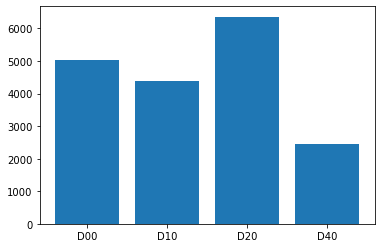

In [11]:
from collections import Counter
c = Counter()
for i in range(len(train_dataset)):
    labels = train_dataset.annoDict[i]['labels'].tolist()
#     print(labels)
    c.update(labels)

for i in range(len(val_dataset)):
    labels = val_dataset.annoDict[i]['labels'].tolist()
#     print(labels)
    c.update(labels)
keys, values = zip(*sorted(c.items()))
plt.bar([categories_dict[key] for key in keys], values)

In [12]:
class WithReplacementRandomSampler(torch.utils.data.Sampler):
    """Samples elements randomly, with replacement.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source):
        self.data_source = data_source

    def __iter__(self):
        # generate samples of `len(data_source)` that are of value from `0` to `len(data_source)-1`
        samples = torch.LongTensor(len(self.data_source))
        samples.random_(0, len(self.data_source))
        return iter(samples)

    def __len__(self):
        return len(self.data_source)

In [13]:
batch_size = 32
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         sampler=WithReplacementRandomSampler(train_dataset),
                                         shuffle=False,
                                         num_workers=12,
                                         collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=12,
                                         collate_fn=collate_fn)

# Visualizing a random batch from the dataloader for a sanity check

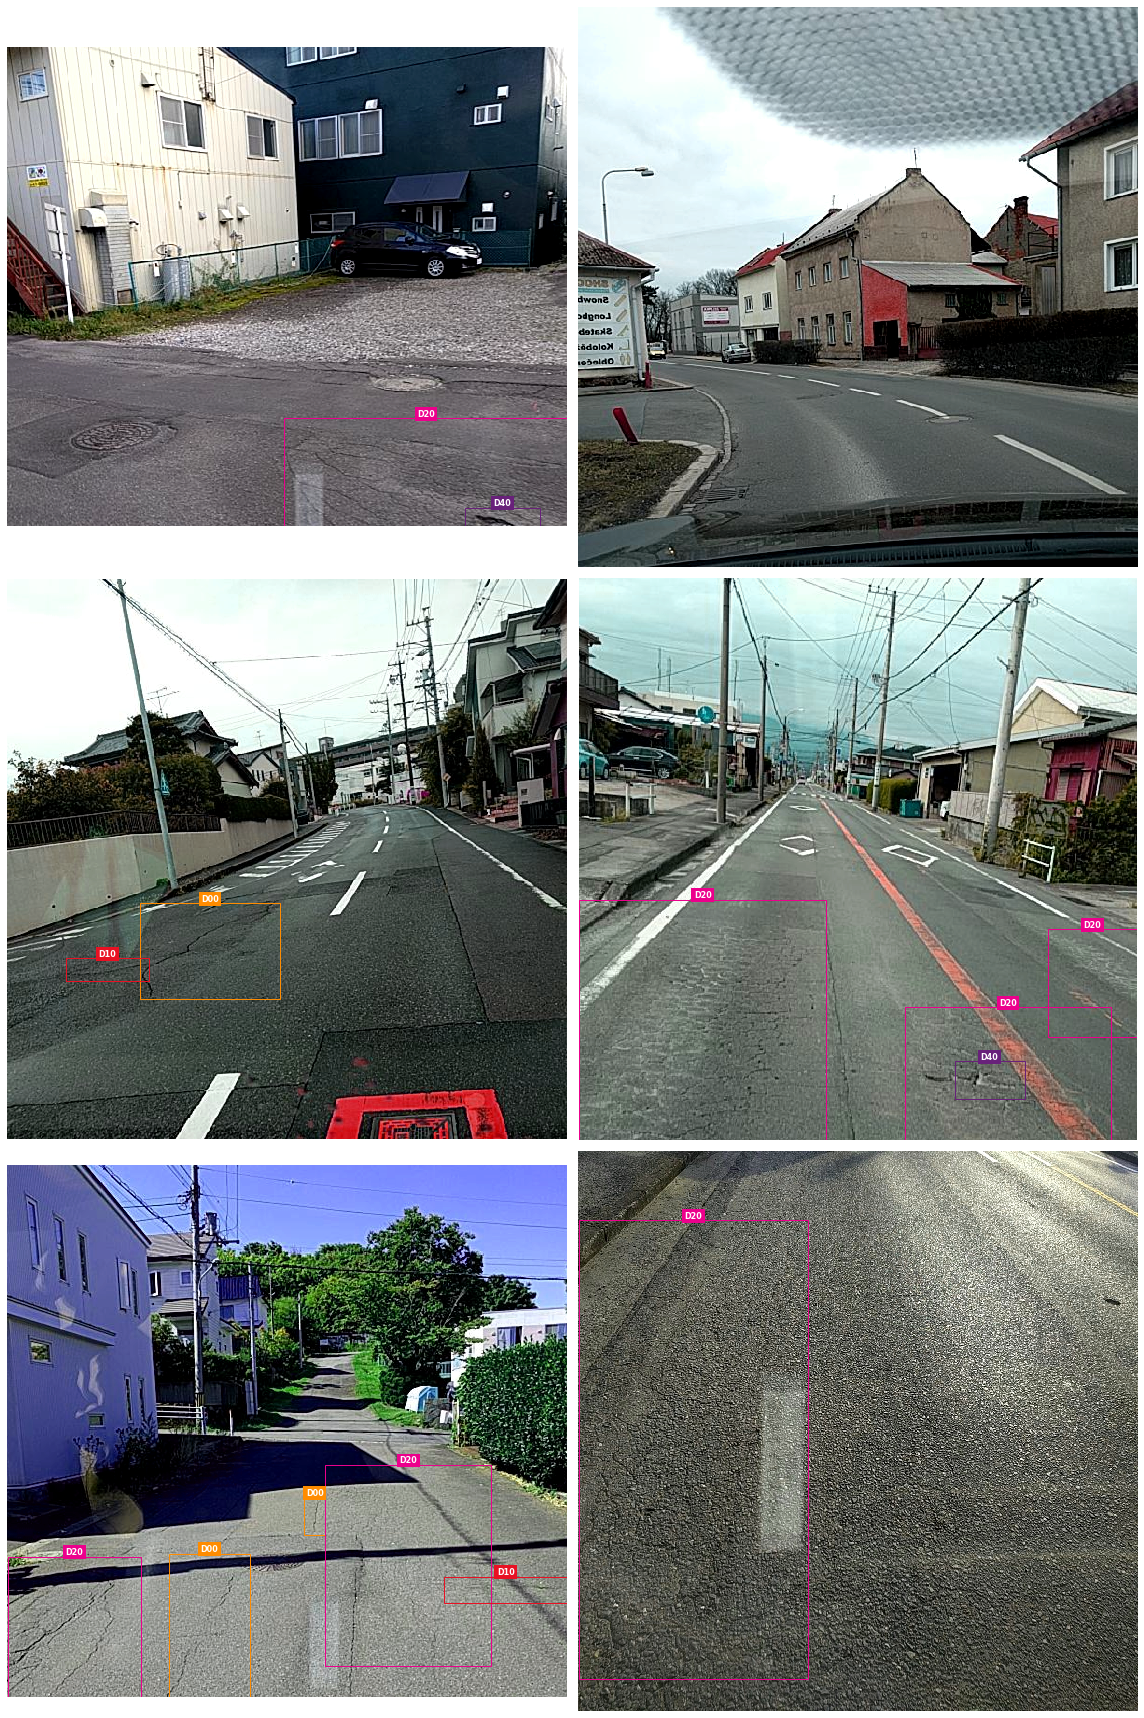

In [15]:
batch = next(iter(train_dataloader))
tensors = batch[0]
metadata = batch[1]
# tensors, metadata
y = min(int(len(tensors)/2+0.5), 3); x = 2
fig = plt.figure(figsize=(8*x, 8*y))
box_style = {'facecolor': 'red',
       'edgecolor': 'none',
       'boxstyle': 'square'
      }
font_style = {
        'color':  'white',
        'weight': 'bold',
        'size': 8
        }

edgecolors = {
    0:'#a19100',
    1:'#ff8c00',
    2:'#e81123',
    3:'#ec008c',
    4:'#68217a',
    5:'#00188f',
    6:'#00bcf2',
    7:'#00b294',
    8:'#009e49',
    9:'#bad80a'
}

for i in range(x*y):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , i + 1)
    cats = metadata[i]['labels'].cpu().numpy().astype(np.int32)
    boxes = metadata[i]['boxes'].cpu().numpy().astype(np.int32)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
#     image = image * 128
    
    for j in range(len(boxes)):
        box = boxes[j]
        cat = cats[j]
        patch = patches.Rectangle((box[0], box[1]), box[2]-box[0],box[3]-box[1], linewidth=1,
                         edgecolor=edgecolors[cat], facecolor="none")
        
        
        box_style = {'facecolor': edgecolors[cat],
               'edgecolor': 'none',
               'boxstyle': 'square'
              }
        ax.add_patch(patch)
        plt.text(
            (box[0] + box[2])/2,
            box[1],
            categories_dict[cat],
            verticalalignment='bottom',
            horizontalalignment='center',
            fontdict=font_style,
            bbox=box_style)


    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    

# Create and train model

In [15]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [16]:
# our dataset has two classes only - background and barrel
num_classes = len(categories) + 1

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]


In [17]:
tensors[0].shape

torch.Size([3, 501, 579])

In [18]:
from torchinfo import summary
summary(model, input_size=(len(tensors), 3, 664, 621))

/usr/lib/python3/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              --                        --
├─BackboneWithFPN: 1                                    --                        --
│    └─FeaturePyramidNetwork: 2                         --                        --
│    │    └─ModuleList: 3-1                             --                        984,064
│    │    └─ModuleList: 3-2                             --                        2,360,320
├─GeneralizedRCNNTransform: 1-1                         --                        --
├─BackboneWithFPN: 1-2                                  [32, 256, 14, 13]         --
│    └─IntermediateLayerGetter: 2-1                     [32, 2048, 27, 25]        --
│    │    └─Conv2d: 3-3                                 [32, 64, 432, 400]        (9,408)
│    │    └─FrozenBatchNorm2d: 3-4                      [32, 64, 432, 400]        --
│    │    └─ReLU: 3-5                      

In [19]:

# construct an optimizer
optimizer = torch.optim.AdamW(params, lr=1.33E-04)
# optimizer = torch.optim.RMSprop(params, lr=0.001, alpha=0.99, eps=1e-08, 
#                                 weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
# lr_sched = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=1,
#                                                gamma=0.25)
epochs = 5

lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                       max_lr=3e-04, 
                       steps_per_epoch=len(train_dataloader), 
                       epochs=epochs)




In [20]:
def train_loop(dataloader, model, optimizer, history, lr_sched = None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    bar_format = "{l_bar}{bar}| {elapsed}<{remaining} |{rate_fmt}{postfix}"
    
    total_loss = 0
    with tqdm(dataloader, unit="batch", desc='Training', bar_format=bar_format) as tepoch:
        for X, y in tepoch:
#             print(X)
            X = list(img.to(device) for img in X)
            y = [{k: v.to(device) for k, v in t.items()} for t in y]

            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                loss_dict = model(X, y)
                losses = sum(loss for loss in loss_dict.values())


            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()

            if(lr_sched is not None):
                lr_sched.step()

            total_loss += losses.item()
            tepoch.set_postfix(
                loss=round(losses.item(), 4)
#                 lr=round(lr_sched.get_last_lr()[0], 4)
            )
        history['train_loss'].append(total_loss/num_batches)

def iou(a,b):
    """
    Description
    -----------
    Calculates intersection over union for all sets of boxes in a and b

    Parameters
    ----------
    a : tensor of size [batch_size,4] 
        bounding boxes
    b : tensor of size [batch_size,4]
        bounding boxes.

    Returns
    -------
    iou - float between [0,1]
        average iou for a and b
    """
    
    area_a = (a[2]-a[0]) * (a[3]-a[1])
    area_b = (b[2]-b[0]) * (b[3]-b[1])
    
    minx = max(a[0], b[0])
    maxx = min(a[2], b[2])
    miny = max(a[1], b[1])
    maxy = min(a[3], b[3])
    
    intersection = max(0, maxx-minx) * max(0,maxy-miny)
    union = area_a + area_b - intersection
    iou = intersection/union
    
    return iou

def score_pred(pred_boxes, pred_label, gold_boxes, gold_label, scores):
    gold_available = [i for i in range(len(gold_boxes))]
    for label in gold_label:
        scores[categories_dict[label.item()]]['targets']+=1
    for i, pred_b in enumerate(pred_boxes):
        scores[categories_dict[pred_label[i].item()]]['shots']+=1
        for j in gold_available:
            gold_b = gold_boxes[j]
#             print(pred_label, gold_label, pred_b, gold_b, iou(pred_b, gold_b))
            if pred_label[i] == gold_label[j] and iou(pred_b, gold_b) > 0.5:
                gold_available.remove(j)
                scores[categories_dict[pred_label[i].item()]]['hits']+=1

    
def test_loop(dataloader, model, history):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0

    accuracy_metrics = {}
    for i in categories:
        accuracy_metrics[i] = {'hits':0, 'shots':0, 'targets':0}
    
    bar_format = "{l_bar}{bar}| {elapsed}<{remaining} |{rate_fmt}{postfix}"
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing ", unit="batches", bar_format=bar_format):
            X = list(img.to(device) for img in X)
            
            outputs = model(X)
#             outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

            for i in range(len(outputs)):
                threshold = outputs[i]['scores'].cpu() > 0.5
                boxes = outputs[i]['boxes'].cpu()[threshold]
                labels = outputs[i]['labels'].cpu()[threshold]
                
                assert(len(boxes) == len(labels))
                assert(len(y[i]['boxes']) == len(y[i]['labels']))
                
                score_pred(boxes, labels, y[i]['boxes'], y[i]['labels'], accuracy_metrics)
    
    for category in accuracy_metrics:
        i = accuracy_metrics[category]
        shots = i['shots']
        hits = i['hits']
        targets = i['targets']
        precision = 0.
        if shots > 0:
            precision = i['hits']/i['shots']
        i['precision'] = precision
        
        recall = 0.
        if targets > 0:
            recall = i['hits']/i['targets']
        i['recall'] = recall
        
        f1score = 0.
        if precision > 0 and recall > 0:
            f1score = (2 * precision * recall)/(precision + recall)
        i['f1score'] = f1score
        
    loss /= num_batches
    history['accuracy_metrics'].append(accuracy_metrics)
    

In [ ]:
# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()

history = {
    'train_loss':[],
    'accuracy_metrics':[]
}

begin = time.time()
  
for epoch in range(epochs):
    print()
    print(f'Epoch {epoch+1}')
    print("-------------")
    train_loop(train_dataloader, model, optimizer, history)
    test_loop(val_dataloader, model, history)
#     print(f"Training Loss: {history['train_loss'][-1]:.5}\t    Testing Loss: {history['test_loss'][-1]:.5}")
    accuracy_metric = history['accuracy_metrics'][-1]
    for i in accuracy_metric:
        print(f"{i:<8}  |   Precision: {accuracy_metric[i]['precision']:8.5f}     Recall: {accuracy_metric[i]['recall']:8.5f}")

end = time.time()


# watch -d -n 0.5 nvidia-smi


Epoch 1
-------------


Training:  84%|████████▍ | 28:39<04:43 | 4.72s/batch, loss=0.258  

# Store Model and Eval/Train metrics

In [26]:
version = 'v31-training-full'

model_root = proj_root_path / "models"
assert(model_root.exists())

inf_model_name = f"{version}_inf.pth"
ent_model_name = f"{version}_full.pth"
torch.save(model.state_dict(), model_root / inf_model_name)
torch.save(model, model_root / ent_model_name)

In [29]:
average_metrics = []
for entry in history['accuracy_metrics']:
    precision = 0
    recall = 0
#     print(entry)
    for category in entry:
        recall += entry[category]['recall']
        precision += entry[category]['precision']
    metrics = {}
    metrics['precision'] = precision = precision/len(entry)
    metrics['recall'] = recall = recall/len(entry)
    metrics['f1score'] = 0
    if precision > 0 and recall > 0:
        metrics['f1score'] = (2 * precision * recall)/(precision + recall)
    average_metrics.append(metrics)
average_metrics[-1]

{'precision': 0.3869256054345075,
 'recall': 0.47479650144927593,
 'f1score': 0.4263809000927102}

In [30]:
from datetime import datetime
import json 

run_details = {
    'desc':version,
    'runtime':datetime.now().astimezone().strftime('%c'),
    'num_params': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'lr_scheduler': 'OneCycleLR(max_lr=3e-4)',
    'optimizer': 'AdamW',
    'model':'FasterRCNN-resnet50',
    'time_taken':end-begin,
    'history':history,
    'average_metrics':average_metrics,
    'best_f1_score': max([i['f1score'] for i in average_metrics])
}

log_dir = proj_root_path / 'log'
if not log_dir.exists():
    log_dir.mkdir()

datestring = datetime.now().astimezone().strftime("%Y%m%d")

with open(log_dir/f"{datestring}-{run_details['desc']}", 'w') as fout:
    json_object = json.dumps(run_details, indent = 4) 
    print(json_object)
    fout.write(json_object)


{
    "desc": "v31-training-full",
    "runtime": "Fri Apr  8 18:59:38 2022",
    "num_params": 41092136,
    "lr_scheduler": "OneCycleLR(max_lr=3e-4)",
    "optimizer": "AdamW",
    "model": "FasterRCNN-resnet50",
    "time_taken": 8613.076270580292,
    "history": {
        "train_loss": [
            0.30654858024989035,
            0.24547055755999495,
            0.23892395257791307,
            0.22942529214506455,
            0.22221925618879973
        ],
        "accuracy_metrics": [
            {
                "D00": {
                    "hits": 39,
                    "shots": 88,
                    "targets": 501,
                    "precision": 0.4431818181818182,
                    "recall": 0.07784431137724551,
                    "f1score": 0.13242784380305603
                },
                "D10": {
                    "hits": 0,
                    "shots": 0,
                    "targets": 433,
                    "precision": 0.0,
                    "recal

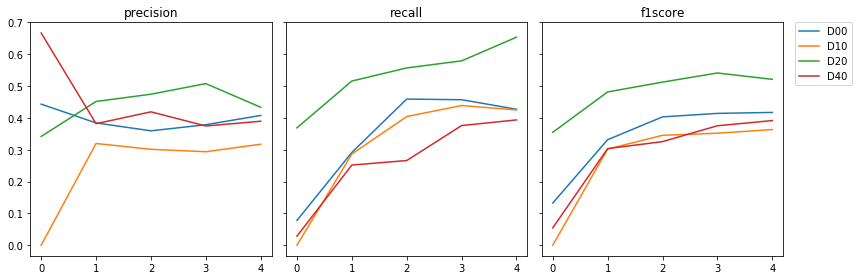

In [31]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12,4))
# axs = [j for ax in axs for j in ax]
accuracy_metrics = history['accuracy_metrics']
# We can set the number of bins with the *bins* keyword argument.
for i, metric in enumerate(['precision', 'recall','f1score']):
    for category in accuracy_metrics[0]:
        axs[i].plot([x[category][metric] for x in accuracy_metrics], label=f'{category}' )
        axs[i].set_title(metric)
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

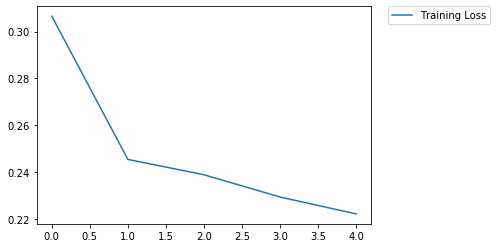

In [32]:
epochs_range = range(len(history['train_loss']))

# plt.figure(figsize=(8,8))
# plt.subplots(1,2,1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

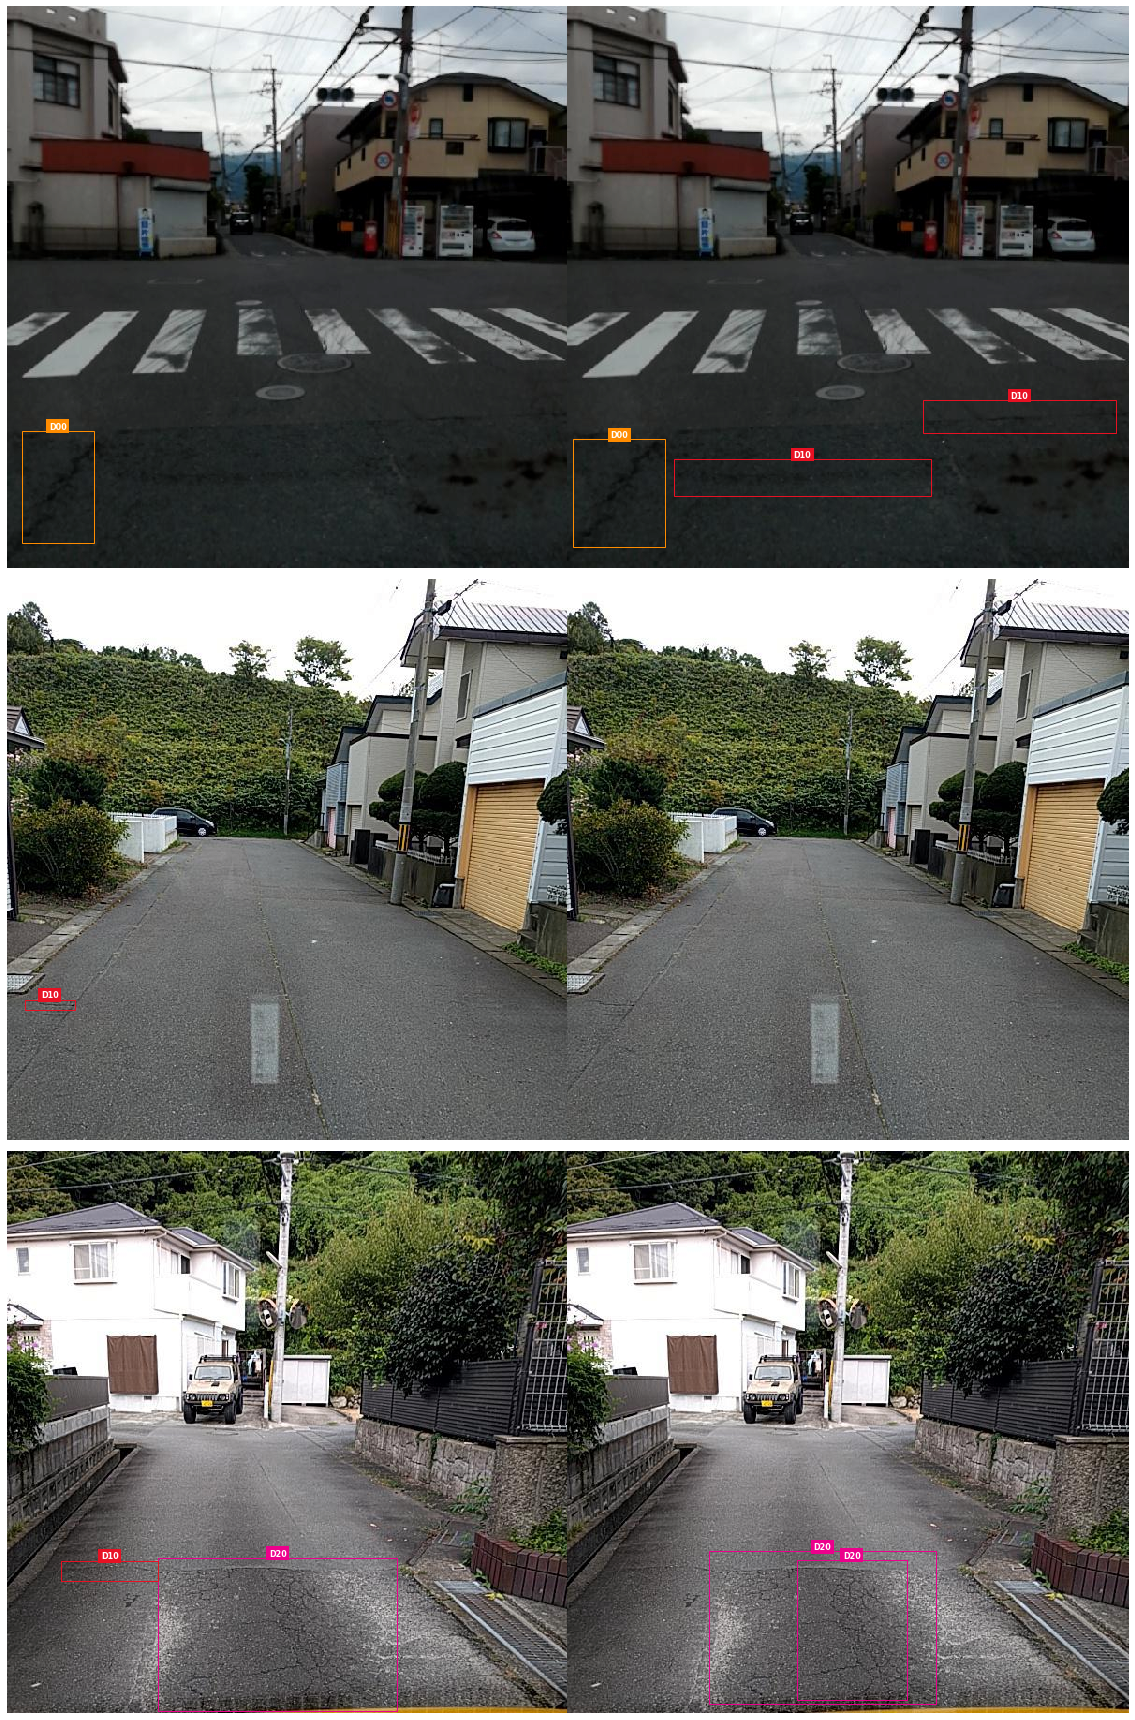

In [21]:
### Uncomment to load model
# version = 'v31-training-full'

# model_root = proj_root_path / "models"
# assert(model_root.exists())

# ent_model_name = f"{version}_full.pth"
# model = torch.load(model_root / ent_model_name)
# model.to(device)
# model.eval()

images, labels = next(iter(val_dataloader))
images = list(img.to(device) for img in images)

with torch.no_grad():
    outputs = model(images)

y = min(len(tensors), 3)
x = 2
fig, axes = plt.subplots(y, x, sharey=True, tight_layout=True, figsize=(8*x, 8*y))

for i in range(y):
    cats = labels[i]['labels'].cpu().numpy().astype(np.int32)
    boxes = labels[i]['boxes'].cpu().numpy().astype(np.int32)
    image = images[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    
    for j in range(len(boxes)):
        box = boxes[j]
        cat = cats[j]
        patch = patches.Rectangle((box[0], box[1]), box[2]-box[0],box[3]-box[1], linewidth=1,
                         edgecolor=edgecolors[cat], facecolor="none")
        
        
        box_style = {'facecolor': edgecolors[cat],
               'edgecolor': 'none',
               'boxstyle': 'square'
              }
        axes[i][0].add_patch(patch)
        axes[i][0].text(
            (box[0] + box[2])/2,
            box[1],
            categories_dict[cat],
            verticalalignment='bottom',
            horizontalalignment='center',
            fontdict=font_style,
            bbox=box_style)


    axes[i][0].set_axis_off()
    axes[i][0].imshow(image)
    
    threshold = outputs[i]['scores'].cpu() > 0.5
    boxes = outputs[i]['boxes'].cpu()[threshold].numpy().astype(np.int32)
    cats = outputs[i]['labels'].cpu()[threshold].numpy().astype(np.int32)
    
#     cats = outputs[i]['labels'].cpu().numpy().astype(np.int32)
#     boxes = outputs[i]['boxes'].cpu().numpy().astype(np.int32)

    
    for j in range(len(boxes)):
        box = boxes[j]
        cat = cats[j]
        patch = patches.Rectangle((box[0], box[1]), box[2]-box[0],box[3]-box[1], linewidth=1,
                         edgecolor=edgecolors[cat], facecolor="none")
        
        
        box_style = {'facecolor': edgecolors[cat],
               'edgecolor': 'none',
               'boxstyle': 'square'
              }
        axes[i][1].add_patch(patch)
        axes[i][1].text(
            (box[0] + box[2])/2,
            box[1],
            categories_dict[cat],
            verticalalignment='bottom',
            horizontalalignment='center',
            fontdict=font_style,
            bbox=box_style)


    axes[i][1].set_axis_off()
    axes[i][1].imshow(image)
